In [30]:
DATASET_NAME = "DRIVE" # DRIVE, CVC_ClinicDB, LUNGS, ISIC2018, ISBI2012_EM
CFG_NAME = "Unet"

In [31]:
# Import libraries

import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
import numpy as np
from skimage.transform import resize
import time
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import callbacks
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from keras.models import load_model

import models as M
import losses as l

ROOT_DIR = os.path.abspath("./")
LOG_PATH = os.path.join(ROOT_DIR, "logs")
TARGET_PATH = os.path.join(LOG_PATH, "{}_{}".format(DATASET_NAME, CFG_NAME))
print(os.listdir(TARGET_PATH))

['DRIVE_Unet.h5', 'DRIVE_Unet_jacard.txt', 'DRIVE_Unet_jac_graph.pdf', 'DRIVE_Unet_loss_graph.pdf', 'DRIVE_Unet_REPORT.txt', 'DRIVE_Unet_inputs.npy', 'DRIVE_Unet_predicted_masks.npy', 'results', 'DRIVE_Unet_loss.txt', 'DRIVE_Unet_masks.npy']


In [32]:
## Visualizing the Hidden Layer Representations
def filter_vis(target_layers, path, gauss=False):
    
    
    if gauss == False:
        tag = "unet"
        flag = ""
    else:
        tag = "gauss_unet"
        flag = " after Gauss Layer"
    
    layer_names = []
    for layer in target_layers:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
    ct = 1
    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * 1, images_per_row * size)) # n_cols
        
        for col in range(1): # n_cols,     Tiles each filter into a big horizontal grid
            for row in range(images_per_row): 
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]

                if channel_image.shape[0] != channel_image.shape[1]:
                    # Resize
                    DIM = (channel_image.shape[0], channel_image.shape[0])
                    channel_image = resize(channel_image, DIM, mode='constant')

                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name + flag)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='magma')
        plt.savefig("{}/{}_{}.png".format(path, layer_name, tag), dpi=100)

In [33]:
# Load input images
images = np.load("{}/{}_{}_inputs.npy".format(TARGET_PATH, DATASET_NAME, CFG_NAME))
images.shape

(8, 512, 512, 3)

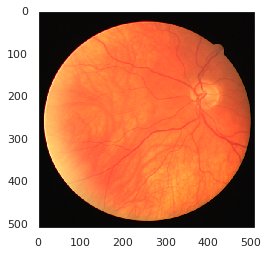

In [34]:
plt.grid(False)
plt.imshow(np.squeeze(images[0]))

In [42]:
model = None
#model = load_model("{}/{}_{}.h5".format(TARGET_PATH, DATASET_NAME, CFG_NAME), compile=False)
#model = load_model("{}/{}_{}.h5".format(TARGET_PATH, DATASET_NAME, CFG_NAME), compile=False)
model = load_model("/home/hasib/gaussianU-Net/logs/DRIVE_Gauss_Unet/DRIVE_Gauss_Unet.h5", compile=False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [43]:
len(model.layers)

32

In [44]:
# layer every conv layer which are in skip connection
target_layers = [model.layers[16], model.layers[20], model.layers[24], model.layers[28]]
for layer in target_layers:
        print(layer.name)
        
# layer outputs
layer_outputs = [layer.output for layer in target_layers]
layer_outputs

concatenate_1
concatenate_2
concatenate_3
concatenate_4


[<tf.Tensor 'concatenate_1_4/concat:0' shape=(None, 64, 64, 512) dtype=float32>,
 <tf.Tensor 'concatenate_2_4/concat:0' shape=(None, 128, 128, 256) dtype=float32>,
 <tf.Tensor 'concatenate_3_4/concat:0' shape=(None, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'concatenate_4_4/concat:0' shape=(None, 512, 512, 64) dtype=float32>]

In [45]:
## Generation of Activation Maps
from keras import models
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# Creates a model that will return these outputs, given the model input
#activation_model.summary()

In [46]:
## Generating the activation map for a input image
img_tensor = images[0:1]
activations = activation_model.predict(img_tensor)

In [47]:
try:
    # directory to create
    os.mkdir(os.path.join(TARGET_PATH, "filtervis"))
except FileExistsError:
    # directory already exists
    pass

filter_vis_path = os.path.join(TARGET_PATH, "filtervis")
filter_vis_path

'/home/hasib/gaussianU-Net/logs/DRIVE_Unet/filtervis'

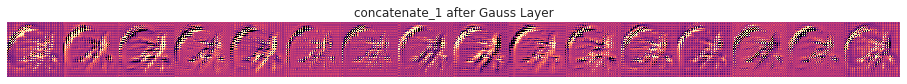

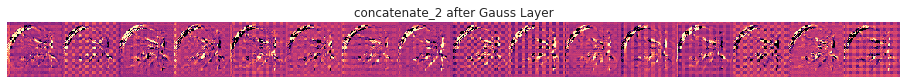

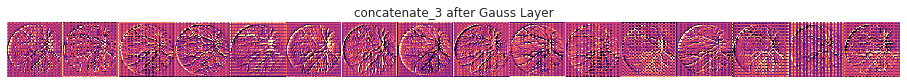

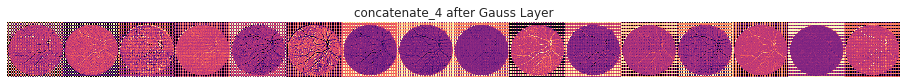

In [48]:
filter_vis(target_layers, filter_vis_path, gauss=True)